In [240]:
import os
import sys

# Добавляем корневую директорию проекта в sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Импортируем metrics из utils
from utils import metrics as mtc

In [241]:
import itertools
import re

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util

# Advanced preprocessing reference - без него никуда

1. Выделяем аббревиатуры до приведения к нижнему регистру для их расшифровки.
2. Переводим аббревиатуры в текст.
3. Отдельно следует учесть, что аббревиатуры могут быть в нижнем регистре и смешанно. Поэтому все аббревиатуры следует привести в нижний регистр и искать их. Но, сначала, следует их найти по верхему регистру - вдруг они новые. Можно дообучить модель.
4. Приводим к нижнему регистру.
5. Проводим лемматизацию, в том числе всех регионов.
6. 
7. Выделяем регионы (учитывая, что некоторые регионы были зашифрованы в аббревиатурах).
8. 

In [242]:
reference = pd.read_csv("../../data/reference.csv")
train = pd.read_csv("../../data/splited/train.csv")
valid = pd.read_csv("../../data/splited/valid.csv")
test = pd.read_csv("../../data/splited/test.csv")

In [243]:
reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      305 non-null    int64 
 1   name    305 non-null    object
 2   region  305 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.3+ KB


In [244]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       551 non-null    object
 1   school_id  551 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [245]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       184 non-null    object
 1   school_id  184 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [246]:
reference.head()

,id,name,region
0,69,Кировска,Мурманская область
1,70,Клин спортивный,Московская область
2,71,КО СШ по ЗВС,Калининградская область
3,8,Айсберг,Свердловская область
4,73,Команда Дмитриева,Челябинская область


## Выделяем и заменяем аббревиатуры

In [247]:
# добавить СПБ
# abbr_dict =
# joblib.dump(abbr_dict, "../../mats/abbreviations_dict.joblib")



In [248]:
abbr_dict = joblib.load("../../mats/abbreviations_dict.joblib")

In [249]:
def find_and_replace_abbreviations(
    name,
    abbreviation_dict,
    output_list,
    unknown_answer=False,
    remove_unknown_abbr=False,
    remove_all_abbr=False,
):
    two_letter_prepositions = [
        " в ",
        " во ",
        " до ",
        " из ",
        " на ",
        " по ",
        " о ",
        " об ",
        " обо ",
        " у ",
    ]

    symbols = [" no", " NO", " No", "номер"]

    # Удаляем служебные символы (перенос строки, табуляция и т.д.)
    name = re.sub(r"[\n\t\r]", " ", name)

    # Создаем регулярное выражение для предлогов
    prepositions_pattern = (
        r"\b(?:" + "|".join(two_letter_prepositions) + "|".join(symbols) + r")\b"
    )

    # Заменяем все предлоги на пробем (предварительное решение вместо трудоемкого удаления стоп-слов)
    name = re.sub(prepositions_pattern, " ", name)

    # Удаление пунктуации
    name = re.sub(r"[^\w\s]", " ", name)

    # Удаление отдельных букв
    name = re.sub(r"\b[А-ЯЁа-яё]\b", " ", name)

    unknown_abbr = []
    # Находим аббревиатуры большими буквами и приводим их к нижнему регистру
    # Надо уточнить поиск неизвестных.
    # А если в конце аббревиатуры прописная буква?
    uppercase_abbreviations = re.findall(r"\b[А-ЯЁ]+[а-яё]*+[А-ЯЁ]+\b", name)
    for abbr in uppercase_abbreviations:
        abbr = abbr.lower()
        if abbr not in abbreviation_dict:
            unknown_abbr.append(abbr.upper())
            if remove_unknown_abbr:
                name = re.sub(r"\b" + re.escape(abbr.upper()) + r"\b", " ", name)

    # Удаление лишних пробелов
    name = re.sub(r"\s+", " ", name)

    # Удаление пробелов в начале и в конце
    name = name.strip()

    possible_replacements = []
    parts = name.lower().split()

    for part in parts:
        if part in abbreviation_dict:
            if not remove_all_abbr:
                replacements = abbreviation_dict[part]
                if isinstance(replacements, str):
                    replacements = [replacements]
                elif not output_list:
                    replacements = [""]
                possible_replacements.append(replacements)
            else:
                pass
        else:
            possible_replacements.append([part])

    # Генерируем все возможные комбинации
    all_combinations = list(itertools.product(*possible_replacements))

    # Формируем итоговые наименования
    final_phrases = [" ".join(combination).strip() for combination in all_combinations]

    if not output_list:
        final_phrases = final_phrases[0]

    if unknown_answer:
        return list(set(unknown_abbr))

    return final_phrases

In [250]:
# Применяем функцию ко всем строкам столбца name
reference["final_phrases"] = reference["name"].apply(
    find_and_replace_abbreviations,
    args=(
        abbr_dict,
        False,
    ),
)
reference["final_phrases_wo_unknown_abbr"] = reference["name"].apply(
    find_and_replace_abbreviations, args=(abbr_dict, False, False, True)
)
reference["final_phrases_wo_all_abbr"] = reference["name"].apply(
    find_and_replace_abbreviations, args=(abbr_dict, False, False, True, True)
)
reference["unknown_abbr"] = reference["name"].apply(
    find_and_replace_abbreviations, args=(abbr_dict, False, True)
)

In [251]:
reference.head()

,id,name,region,final_phrases,final_phrases_wo_unknown_abbr,final_phrases_wo_all_abbr,unknown_abbr
0,69,Кировска,Мурманская область,кировска,кировска,кировска,[]
1,70,Клин спортивный,Московская область,клин спортивный,клин спортивный,клин спортивный,[]
2,71,КО СШ по ЗВС,Калининградская область,спортивная школа зимние виды спорта,спортивная школа зимние виды спорта,,[]
3,8,Айсберг,Свердловская область,айсберг,айсберг,айсберг,[]
4,73,Команда Дмитриева,Челябинская область,команда дмитриева,команда дмитриева,команда дмитриева,[]


In [252]:
# Применяем функцию ко всем строкам столбца name
train["final_phrases"] = train["name"].apply(
    find_and_replace_abbreviations,
    args=(
        abbr_dict,
        False,
    ),
)
train["final_phrases_wo_unknown_abbr"] = train["name"].apply(
    find_and_replace_abbreviations, args=(abbr_dict, False, False, True)
)
train["final_phrases_wo_all_abbr"] = train["name"].apply(
    find_and_replace_abbreviations, args=(abbr_dict, False, False, True, True)
)
train["unknown_abbr"] = train["name"].apply(
    find_and_replace_abbreviations, args=(abbr_dict, False, True)
)

In [253]:
# Применяем функцию ко всем строкам столбца name
valid["final_phrases"] = valid["name"].apply(
    find_and_replace_abbreviations,
    args=(
        abbr_dict,
        False,
    ),
)
valid["final_phrases_wo_unknown_abbr"] = valid["name"].apply(
    find_and_replace_abbreviations, args=(abbr_dict, False, False, True)
)
valid["final_phrases_wo_all_abbr"] = valid["name"].apply(
    find_and_replace_abbreviations, args=(abbr_dict, False, False, True, True)
)
valid["unknown_abbr"] = valid["name"].apply(
    find_and_replace_abbreviations, args=(abbr_dict, False, True)
)

In [254]:
train.head()

,name,school_id,final_phrases,final_phrases_wo_unknown_abbr,final_phrases_wo_all_abbr,unknown_abbr
0,"Москва, ГБУ МАФКК школа ""Мечта""",102,москва государственное бюджетное учреждение мо...,москва государственное бюджетное учреждение мо...,москва школа мечта,[]
1,"Калужская область, СШ ""Космос""",78,калужская область спортивная школа космос,калужская область спортивная школа космос,калужская область космос,[]
2,"МО 7-й округ, ООО ""Династия""",49,7 округ общество с ограниченной ответственност...,7 округ общество с ограниченной ответственност...,7 округ династия,[]
3,АНФСО СКФК Спартак,164,автономная некоммерческая физкультурно-спортив...,автономная некоммерческая физкультурно-спортив...,спартак,[]
4,"Челябинская область, ИП Дмитриев А.А.",73,челябинская область индивидуальный предпринима...,челябинская область индивидуальный предпринима...,челябинская область дмитриев,[]


# Дальнейшая обработка текстов

In [255]:
reference.region = reference.region.str.lower().str.strip()

In [256]:
reference.region = reference.region.str.replace("г ", "")
reference.region = reference.region.str.replace("г. ", "")
reference.region = reference.region.str.replace("г.", "")
reference.region = reference.region.str.replace(
    "хмао-югра", "ханты мансийский автономный округ"
)
reference.region = reference.region.str.replace("спб", "санкт петербург")
reference.region = reference.region.str.replace(
    "ямало-ненецкий ао", "ямало ненецкий автономный округ"
)
reference.region = reference.region.str.replace(
    "республика чувашия", "чувашская республика"
)
reference.region = reference.region.str.replace("северодвинск", "архангельская область")
reference.region = reference.region.str.replace(
    "набережные челны", "республика татарстан"
)
reference.region = reference.region.str.replace("санкт-петербург", "санкт петербург")

In [257]:
reference.region.sort_values().unique()

array(['алтайский край', 'архангельская область', 'астраханская область',
       'белгородская область', 'брянская область', 'владимирская область',
       'волгоградская область', 'вологодская область',
       'воронежская область', 'забайкальский край', 'ивановская область',
       'иркутская область', 'калининградская область',
       'калужская область', 'кемеровская область', 'кировская область',
       'костромская область', 'краснодарский край', 'красноярский край',
       'курганская область', 'курская область', 'ленинградская область',
       'липецкая область', 'москва', 'московская область',
       'мурманская область', 'нижегородская область',
       'новгородская область', 'новосибирская область', 'омская область',
       'оренбургская область', 'орловская область', 'пензенская область',
       'пермский край', 'приморский край', 'псковская область',
       'республика башкортостан', 'республика карелия', 'республика коми',
       'республика крым', 'республика марий эл', 

In [258]:
reference["reference"] = reference["region"] + " " + reference["final_phrases"]

# Лемматизация, токенезация и удаление стоп-слов

In [259]:
import nltk
import pymorphy3
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Загружаем необходимые ресурсы

nltk.download("punkt")

nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\filat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [260]:
# Инициализация морфологического анализатора для русского языка
morph = pymorphy3.MorphAnalyzer()

In [261]:
# Пример функции для обработки текста
def preprocess_text(text):
    # Токенизация
    words = word_tokenize(text.lower(), language="russian")

    # Лемматизация
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]

    # Удаление стоп-слов
    stop_words = set(stopwords.words("russian"))
    filtered_words = [word for word in lemmatized_words if word not in stop_words]

    return " ".join(filtered_words)

In [264]:
reference.reference = reference.reference.apply(preprocess_text)

In [265]:
train.final_phrases = train.final_phrases.apply(preprocess_text)

In [266]:
valid.final_phrases = valid.final_phrases.apply(preprocess_text)

In [267]:
reference[["id", "reference"]].to_csv(
    "../../data/preprocessed/SentenceTransformer_LaBSE/reference.csv", index=False
)
train[["name", "school_id", "final_phrases"]].to_csv(
    "../../data/preprocessed/SentenceTransformer_LaBSE/train.csv", index=False
)
valid[["name", "school_id", "final_phrases"]].to_csv(
    "../../data/preprocessed/SentenceTransformer_LaBSE/valid.csv", index=False
)

# Моделирование SentenceTransformer

### Преобразования в np.array

In [268]:
# Инициализируем модель
# model = SentenceTransformer("LaBSE")



In [277]:
# Инициализируем модель
model = torch.load(
    "../../data/preprocessed/SentenceTransformer_LaBSE/model.pt",
    map_location=torch.device("cpu"),
)

In [278]:
valid = pd.read_csv("../../data/preprocessed/SentenceTransformer_LaBSE/valid.csv")
reference = pd.read_csv(
    "../../data/preprocessed/SentenceTransformer_LaBSE/reference.csv"
)

In [279]:
goal = "final_phrases"
x = valid[goal].to_numpy(dtype="str").flatten()
y = valid["school_id"].to_numpy(dtype="int").flatten()
reference_id = reference["id"].to_numpy(dtype="int").flatten()
reference_name = reference["reference"].to_numpy(dtype="str").flatten()

In [280]:
# Векторизация текстов
reference_embeddings = model.encode(reference_name, convert_to_tensor=True)
query_embeddings = model.encode(x, convert_to_tensor=True)

In [281]:
def find_matches_cosine(x_vec, reference_id, reference_vec, top_k=5, threshold=0.9):
    y_pred = []
    manual_review = []

    for x in x_vec:
        # Вычисляем косинусное сходство между x и всеми векторами reference_vec
        similarities = F.cosine_similarity(x.unsqueeze(0), reference_vec, dim=1)

        # Находим индексы top_k наиболее похожих векторов
        top_indices = torch.topk(similarities, k=top_k).indices
        max_similarity = torch.max(similarities).item()  # Нормализуем значение сходства

        if max_similarity < threshold:
            manual_review.append(x)
            top_matches = [(None, 0.0)] * top_k
        else:
            top_matches = [
                (reference_id[i], similarities[i].item()) for i in top_indices
            ]
            if len(top_matches) < top_k:
                top_matches += [(None, 0.0)] * (top_k - len(top_matches))

        y_pred.append(top_matches)

    return y_pred, manual_review

In [283]:
y_pred, manual_review = find_matches_cosine(
    query_embeddings, reference_id, reference_embeddings, top_k=5, threshold=0.67
)

metrics = mtc.calculate_metrics(y, y_pred, manual_review)
metrics

{'Accuracy@1': 0.406,
 'Accuracy@3': 0.554,
 'Accuracy@5': 0.594,
 'auto_error_rate': 0.594,
 'manual_processing_rate': 0.049,
 'general_error': 0.565}

In [284]:
# Массив значений threshold
threshold_values = np.linspace(0.1, 1.0, 25)

# Запуск функции и сбор метрик
metrics_list = []
for threshold in threshold_values:
    y_pred, manual_review = find_matches_cosine(
        query_embeddings,
        reference_id,
        reference_embeddings,
        top_k=5,
        threshold=threshold,
    )
    metrics = mtc.calculate_metrics(y, y_pred, manual_review)
    metrics_list.append(metrics)

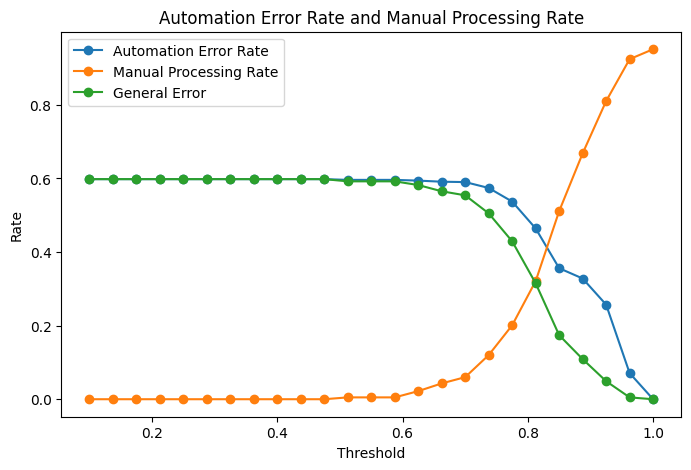

: 

In [285]:
# Преобразование метрик в удобный формат для построения графика
auto_error_rate_values = [metrics["auto_error_rate"] for metrics in metrics_list]
manual_processing_rate_values = [
    metrics["manual_processing_rate"] for metrics in metrics_list
]
# general_spend_values = [metrics['general_spend'] for metrics in metrics_list]
general_error_values = [metrics["general_error"] for metrics in metrics_list]

# Определение общих границ для оси y
y_min = min(min(auto_error_rate_values), min(manual_processing_rate_values))
y_max = max(max(auto_error_rate_values), max(manual_processing_rate_values))

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    threshold_values, auto_error_rate_values, marker="o", label="Automation Error Rate"
)
plt.plot(
    threshold_values,
    manual_processing_rate_values,
    marker="o",
    label="Manual Processing Rate",
)
plt.plot(threshold_values, general_error_values, marker="o", label="General Error")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Automation Error Rate and Manual Processing Rate")
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(threshold_values, general_spend_values, marker='o', label='General Spend')
# plt.xlabel('Threshold')
# plt.ylabel('Money')
# plt.title('General Spend as Threshold')
# plt.legend()


# plt.tight_layout()
plt.show()

In [562]:
# Инициализируем модель
model = SentenceTransformer("sberbank-ai/sbert_large_nlu_ru")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [733]:
# Инициализируем модель
model = SentenceTransformer("LaBSE")

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [734]:
reference_embed = model.encode(
    reference["final_phrases"].values, convert_to_tensor=True
)

In [735]:
train["final_phrases"][0]

'москва государственное бюджетное учреждение московская академия фигурного катания на коньках школа мечта'

In [736]:
train["final_phrases_wo_all_abbr"][0]

'москва школа мечта'

In [737]:
query_embed = model.encode(
    train["final_phrases_wo_all_abbr"][0], convert_to_tensor=True
)

In [738]:
train["school_id"][0]

102

In [739]:
reference[reference.id == 102]

,id,name,region,final_phrases,final_phrases_wo_unknown_abbr,final_phrases_wo_all_abbr,unknown_abbr
97,102,Мечта,Москва,мечта,мечта,мечта,[]


In [741]:
search_result = util.semantic_search(query_embed, reference_embed, top_k=5)

search_result

[[{'corpus_id': 97, 'score': 0.6021506786346436},
  {'corpus_id': 163, 'score': 0.5951200127601624},
  {'corpus_id': 230, 'score': 0.592901885509491},
  {'corpus_id': 101, 'score': 0.580794632434845},
  {'corpus_id': 178, 'score': 0.5796326994895935}]]

In [742]:
reference["final_phrases"].values[97]

'мечта'

In [743]:
reference["final_phrases"].values[163]

'спортивная школа'

In [744]:
reference["final_phrases"].values[230]

'спортивный клуб фигурного катания москвиной'

In [746]:
query_text = "школа мечта"

reference_texts = [
    "школа мечта",
    "школа",
    "мечта",
    "спортивная школа",
    "москва",
]

query_text_em = model.encode(query_text, convert_to_tensor=True)
reference_texts_em = model.encode(reference_texts, convert_to_tensor=True)

util.semantic_search(query_text_em, reference_texts_em, top_k=5)

[[{'corpus_id': 0, 'score': 1.0000001192092896},
  {'corpus_id': 1, 'score': 0.7317617535591125},
  {'corpus_id': 2, 'score': 0.7283006310462952},
  {'corpus_id': 3, 'score': 0.696265459060669},
  {'corpus_id': 4, 'score': 0.4366022050380707}]]

In [747]:
query_text = "мечта школа"

reference_texts = [
    "школа мечта",
    "школа",
    "мечта",
    "спортивная школа",
    "москва",
]

query_text_em = model.encode(query_text, convert_to_tensor=True)
reference_texts_em = model.encode(reference_texts, convert_to_tensor=True)

util.semantic_search(query_text_em, reference_texts_em, top_k=5)

[[{'corpus_id': 0, 'score': 0.9808474779129028},
  {'corpus_id': 1, 'score': 0.7296042442321777},
  {'corpus_id': 3, 'score': 0.7171162366867065},
  {'corpus_id': 2, 'score': 0.7049658894538879},
  {'corpus_id': 4, 'score': 0.42924055457115173}]]

Для реализации задачи обучение модели не требуется. Используем сразу валидационный датасет

In [61]:
valid = pd.read_csv("../../data/preprocessed/cosine/valid.csv")
reference = pd.read_csv("../../data/preprocessed/cosine/reference.csv")

In [62]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       184 non-null    object
 1   school_id  184 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [63]:
reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         305 non-null    int64 
 1   reference  305 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.9+ KB


### Преобразования в np.array

In [64]:
x = valid["name"].to_numpy(dtype="<U25").flatten()
y = valid["school_id"].to_numpy(dtype="int").flatten()
reference_id = reference["id"].to_numpy(dtype="int").flatten()
reference_name = reference["reference"].to_numpy(dtype="<U25").flatten()

### Функции расчета метрик и simple-предсказаний

In [65]:
def accuracy_top_k(y_true, y_pred, k):
    correct = 0
    valid_count = 0  # Счетчик для валидных предсказаний
    for true_id, pred_list in zip(y_true, y_pred):
        top_k_ids = [pred[0] for pred in pred_list[:k] if pred[0] is not None]
        if top_k_ids:
            valid_count += 1
            if true_id in top_k_ids:
                correct += 1
    return correct / valid_count if valid_count > 0 else 0


def check_top_1(true_values, predictions):
    result = []
    for pred_list, true in zip(predictions, true_values):
        if pred_list[0][0] == true:
            result.append(False)
        else:
            result.append(True)
    return result


def calculate_metrics(true_values, predictions, manual_review, cost=1):
    # Accuracy
    accuracy_top_1 = accuracy_top_k(true_values, predictions, 1)
    accuracy_top_3 = accuracy_top_k(true_values, predictions, 3)
    accuracy_top_5 = accuracy_top_k(true_values, predictions, 5)

    # Бизнес-метрика: процент ошибок автоматической обработки
    auto_error_rate = 1 - accuracy_top_1

    # Бизнес-метрика: доля данных, отправленных на ручную обработку данных
    manual_processing_rate = len(manual_review) / len(predictions)

    # manual_spend = len(manual_review) * cost

    # correction_spend = (len(true_values) - len(manual_review)) * cost * 1.5

    # general_error = (
    #     (len(true_values) - len(manual_review)) * auto_error_rate / len(true_values)
    # )

    general_error = (1 - manual_processing_rate) * auto_error_rate

    return {
        "Accuracy@1": round(accuracy_top_1, 3),
        "Accuracy@3": round(accuracy_top_3, 3),
        "Accuracy@5": round(accuracy_top_5, 3),
        "auto_error_rate": round(auto_error_rate, 3),
        "manual_processing_rate": round(manual_processing_rate, 3),
        "general_error": round(general_error, 3),
        # "manual_spend": manual_spend,
        # "correction_spend": correction_spend,
        # "general_spend": manual_spend+correction_spend,
    }

# Построение модели

In [66]:
# Векторизация текстов
vectorizer = TfidfVectorizer().fit(np.append(x, reference_name))
x_vec = vectorizer.transform(x)
reference_vec = vectorizer.transform(reference_name)

In [67]:
def find_matches_cosine(x_vec, reference_id, reference_vec, top_k=5, threshold=0.9):
    y_pred = []
    manual_review = []
    for x in x_vec:
        similarities = cosine_similarity(x, reference_vec).flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        max_similarity = max(similarities)  # Нормализуем значение сходства
        if max_similarity < threshold:
            manual_review.append(x)
            top_matches = [(None, 0.0)] * top_k
        else:
            top_matches = [(reference_id[i], similarities[i]) for i in top_indices]
            if len(top_matches) < top_k:
                top_matches += [(None, 0.0)] * (top_k - len(top_matches))
        y_pred.append(top_matches)
    return y_pred, manual_review

In [68]:
# Массив значений threshold
threshold_values = np.linspace(0.1, 1.0, 10)

# Запуск функции и сбор метрик
metrics_list = []
for threshold in threshold_values:
    y_pred, manual_review = find_matches_cosine(
        x_vec, reference_id, reference_vec, top_k=5, threshold=threshold
    )
    metrics = calculate_metrics(y, y_pred, manual_review)
    metrics_list.append(metrics)

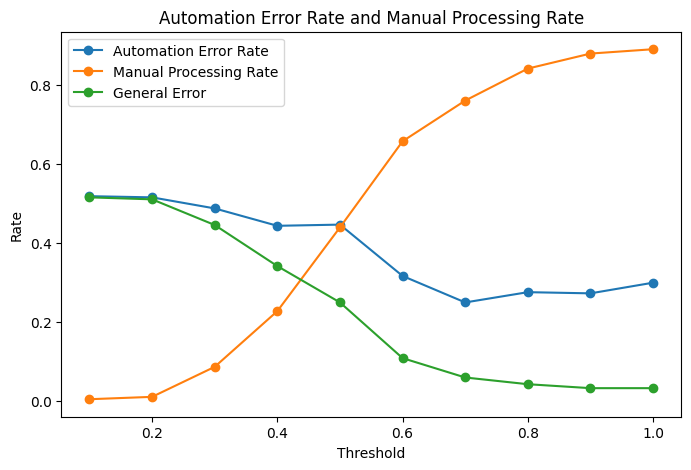

In [69]:
# Преобразование метрик в удобный формат для построения графика
auto_error_rate_values = [metrics["auto_error_rate"] for metrics in metrics_list]
manual_processing_rate_values = [
    metrics["manual_processing_rate"] for metrics in metrics_list
]
# general_spend_values = [metrics['general_spend'] for metrics in metrics_list]
general_error_values = [metrics["general_error"] for metrics in metrics_list]

# Определение общих границ для оси y
y_min = min(min(auto_error_rate_values), min(manual_processing_rate_values))
y_max = max(max(auto_error_rate_values), max(manual_processing_rate_values))

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    threshold_values, auto_error_rate_values, marker="o", label="Automation Error Rate"
)
plt.plot(
    threshold_values,
    manual_processing_rate_values,
    marker="o",
    label="Manual Processing Rate",
)
plt.plot(threshold_values, general_error_values, marker="o", label="General Error")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Automation Error Rate and Manual Processing Rate")
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(threshold_values, general_spend_values, marker='o', label='General Spend')
# plt.xlabel('Threshold')
# plt.ylabel('Money')
# plt.title('General Spend as Threshold')
# plt.legend()


# plt.tight_layout()
plt.show()

In [59]:
y_pred, manual_review = find_matches_cosine(
    x_vec, reference_id, reference_vec, top_k=5, threshold=0.25
)

metrics = calculate_metrics(y, y_pred, manual_review)
metrics

{'Accuracy@1': 0.503,
 'Accuracy@3': 0.674,
 'Accuracy@5': 0.766,
 'auto_error_rate': 0.497,
 'manual_processing_rate': 0.049,
 'general_error': 0.473}

Цель - не более 5% ручного разбора и не менее 95% точности автоматического разбора. Итоговая ошибка составит 4,7%.

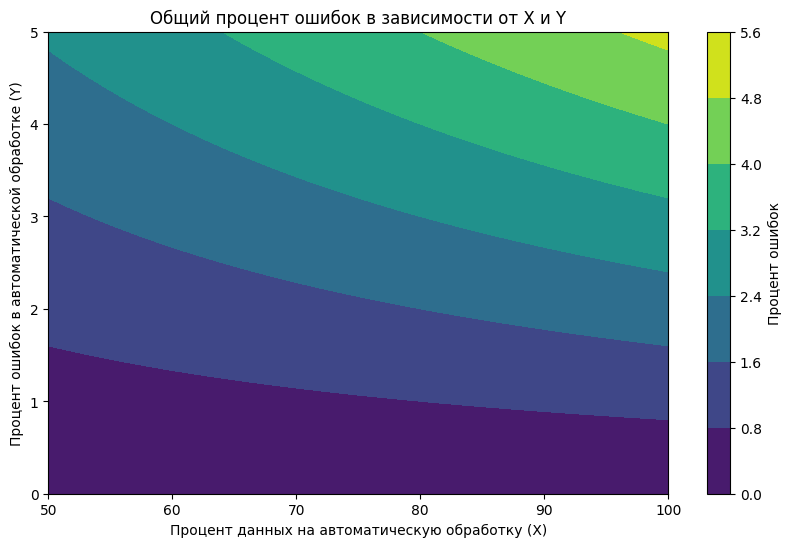

In [180]:
import matplotlib.pyplot as plt
import numpy as np

# Общее количество данных
total_data = 200

# Диапазоны значений для X и Y
X_values = np.linspace(0.5, 1, 100)  # 0% до 100%
Y_values = np.linspace(0, 0.05, 10)  # 0% до 10%

# Матрица для хранения процентов ошибок
error_percentages = np.zeros((len(X_values), len(Y_values)))

# Расчеты
for i, X in enumerate(X_values):
    for j, Y in enumerate(Y_values):
        automatic_data = total_data * X
        errors_in_automatic = automatic_data * Y
        total_errors_percentage = (errors_in_automatic / total_data) * 100
        error_percentages[i, j] = total_errors_percentage

# Создание графика
X_grid, Y_grid = np.meshgrid(
    X_values * 100, Y_values * 100
)  # Преобразование в проценты для осей
plt.figure(figsize=(10, 6))
contour = plt.contourf(X_grid, Y_grid, error_percentages.T, cmap="viridis")
plt.colorbar(contour, label="Процент ошибок")
plt.xlabel("Процент данных на автоматическую обработку (X)")
plt.ylabel("Процент ошибок в автоматической обработке (Y)")
plt.title("Общий процент ошибок в зависимости от X и Y")
plt.show()